In [2]:
# this notebook contains code for matrix completion
# where the input data is

# the actual plots are done on file: "plot_matrix_completion_image.py"

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd
from prettytable import PrettyTable
import time
import pickle
from sklearn.utils.extmath import randomized_svd
from scipy.sparse.linalg import svds

import skimage
import skimage.color
import skimage.io
import skimage.transform

import svt
import fixed_point
import three_split

import utils
from utils import make_support

import importlib
importlib.reload(svt)
importlib.reload(three_split)
importlib.reload(fixed_point)



<module 'fixed_point' from '/Users/gui/my_papers/accelerated_splitting/code/matrix_completion/fixed_point.py'>

Min and max entry values: 0.0005156016639578469 0.9965679609528213
Image size: (974, 1194)
Checking new rank: 70
Min and max entry values of new image: -0.13943334017107673 1.1288451569397326


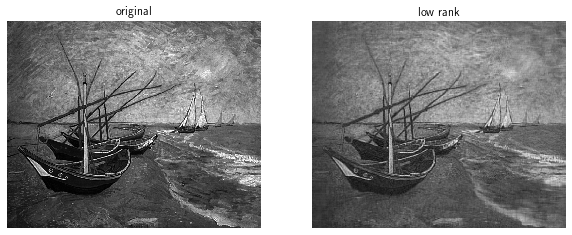

In [9]:
# this is the image we will use

img = skimage.color.rgb2gray(skimage.io.imread('data/van_gogh6.jpg'))
img_small = skimage.transform.rescale(img, 0.5, multichannel=False, preserve_range=True)
print("Min and max entry values:", img_small.min(), img_small.max())

# reducing the rank
U, s, Vt = svds(img_small, k=70)
img_low_rank = U.dot(np.diag(s).dot(Vt))
print("Image size:", img_low_rank.shape)
print("Checking new rank:", np.linalg.matrix_rank(img_low_rank))
print("Min and max entry values of new image:", img_low_rank.min(), img_low_rank.max())

fig = plt.figure(figsize=(10,4))
ax = fig.add_subplot(121)
ax.imshow(img_small, cmap='gray')
ax.set_title('original')
plt.axis('off')
ax = fig.add_subplot(122)
ax.imshow(img_low_rank, cmap='gray')
ax.set_title('low rank')
plt.axis('off')
plt.show()

# Easy Problem

In [9]:
# an easy problem, with high enough sampling rate

M = img_low_rank

n1,n2 = M.shape             # matrix size
r = 70                      # rank
sr = 0.5                    # sampling ratio
p = int(sr*n1*n2)           # number sampled entries
fr = r*(n1+n2-r)/p          # effective degrees of freedom per measurement
rm = int(np.floor((n1+n2-np.sqrt((n1+n2)**2 - 4*p))/2)) # maximum rank
X0 = np.zeros(shape=(n1,n2))

Mnorm = np.linalg.norm(M)
Om = make_support(M.shape, p) # support of observed entries
Mobs = Om*M

t = PrettyTable()
t.field_names = ['rank', 'sampling ratio', 'measurements', 'lower bound', 'lower bound1', 'deg freedom/measurements']
t.add_row([r, sr, p, int(np.power(n2,6./5.)*r*np.log(n2)), n2*r, fr])
print(t)
print(Mobs.min(), Mobs.max(), Mobs.std())

+------+----------------+--------------+-------------+--------------+--------------------------+
| rank | sampling ratio | measurements | lower bound | lower bound1 | deg freedom/measurements |
+------+----------------+--------------+-------------+--------------+--------------------------+
|  70  |      0.5       |    581478    |   2442570   |    83580     |    0.2525632956018972    |
+------+----------------+--------------+-------------+--------------+--------------------------+
-0.13943334017107625 1.127174250473225 0.23644580560783685


In [10]:

mu = 0.05
l1 = -0.15
l2 = 1.15
k = 150
r_nest = 3
r_hb = -np.log(0.9)
#r_nest = 20
#r_hb = -np.log(0.65)
tol = 1e-6
maxiter = 600

# Davis-Yin method and accelerated variants
a = time.time()
X1, rank1 = three_split.davis_yin(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel=None,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X1[-1]-M)/Mnorm, rank1[-1], b)

a = time.time()
X2, rank2 = three_split.davis_yin(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='nest',damp=r_nest,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X2[-1]-M)/Mnorm, rank2[-1], b)

a = time.time()
X3, rank3 = three_split.davis_yin(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='hb',damp=r_hb,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X3[-1]-M)/Mnorm, rank3[-1], b)

# ADMM and accelerated variants
a = time.time()
X4, rank4 = three_split.eadmm(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel=None,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X4[-1]-M)/Mnorm, rank4[-1], b)

a = time.time()
X5, rank5 = three_split.eadmm(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='nest',damp=r_nest,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X5[-1]-M)/Mnorm, rank5[-1], b)

a = time.time()
X6, rank6 = three_split.eadmm(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='hb',damp=r_hb,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X6[-1]-M)/Mnorm, rank6[-1], b)

###############

#a = time.time()
#X7, rank7 = three_split.e2admm(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel=None,l1=l1,l2=l2)
#b = time.time()-a
#print(np.linalg.norm(X7[-1]-M)/Mnorm, rank7[-1], b)

#a = time.time()
#X8, rank8 = three_split.e2admm(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='nest',damp=r_nest,l1=l1,l2=l2)
#b = time.time()-a
#print(np.linalg.norm(X8[-1]-M)/Mnorm, rank8[-1], b)

#a = time.time()
#X9, rank9 = three_split.e2admm(Mobs,Om,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='hb',damp=r_hb,l1=l1,l2=l2)
#b = time.time()-a
#print(np.linalg.norm(X9[-1]-M)/Mnorm, rank9[-1], b)

# computing errors
errors1 = [np.linalg.norm(x-M)/Mnorm for x in X1]
errors2 = [np.linalg.norm(x-M)/Mnorm for x in X2]
errors3 = [np.linalg.norm(x-M)/Mnorm for x in X3]

errors4 = [np.linalg.norm(x-M)/Mnorm for x in X4]
errors5 = [np.linalg.norm(x-M)/Mnorm for x in X5]
errors6 = [np.linalg.norm(x-M)/Mnorm for x in X6]

#errors7 = [np.linalg.norm(x-M)/Mnorm for x in X7]
#errors8 = [np.linalg.norm(x-M)/Mnorm for x in X8]
#errors9 = [np.linalg.norm(x-M)/Mnorm for x in X9]

0.0021118369335117455 70 90.27572512626648
0.002111539801583565 70 37.74375915527344
0.0021114838923963703 70 29.811954975128174
0.0025347024229741603 70 90.29218101501465
0.002534434569021976 70 38.715184926986694
0.0025343824951913787 70 30.464730739593506


In [13]:
# write all results above to file
with open('data/easyfr_fixedrank_all_methods.pickle', 'wb') as f:
    pickle.dump([errors1,errors2,errors3,errors4,errors5,errors6,
                rank1,rank2,rank3,rank4,rank5,rank6], f)

# write one of the recovered matrices
with open('data/easyfr_recoverred_dyhb.pickle','wb') as f:
    pickle.dump(X3[-1], f)

In [15]:
# annealing
# we run this for one method at a time, commenting in/out the specific portion of the code

l1 = -0.15
l2 = 1.15
k = 150
r_nest = 20
r_hb = -np.log(0.65)
tol = 1e-6
maxiter = 600

## choose annealing schedule #######
eta = 0.25
mu = eta*np.linalg.norm(Mobs)
mubar = 1e-8
mus = []
while mu > mubar:
    mu = np.max([eta*mu, mubar])
    mus.append(mu)

# Davis-Yin
X, rank, Xhist, rankhist = utils.warm(three_split.davis_yin,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter)
aerrors1 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
aranks1 = [r for hist in rankhist for r in hist]
print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)

X, rank, Xhist, rankhist = utils.warm(three_split.davis_yin,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='nest',damp=20)
aerrors2 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
aranks2 = [r for hist in rankhist for r in hist]
print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)

X, rank, Xhist, rankhist = utils.warm(three_split.davis_yin,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='hb',damp=-np.log(0.65))
aerrors3 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
aranks3 = [r for hist in rankhist for r in hist]
print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)

# ADMM
X, rank, Xhist, rankhist = utils.warm(three_split.eadmm,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter)
aerrors1 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
aranks1 = [r for hist in rankhist for r in hist]
print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)

X, rank, Xhist, rankhist = utils.warm(three_split.eadmm,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='nest',damp=20)
aerrors2 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
aranks2 = [r for hist in rankhist for r in hist]
print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)

X, rank, Xhist, rankhist = utils.warm(three_split.eadmm,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='hb',damp=-np.log(0.65))
aerrors3 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
aranks3 = [r for hist in rankhist for r in hist]
print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)

# #########

#X, rank, Xhist, rankhist = utils.warm(three_split.e2admm,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter)
#aerrors1 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
#aranks1 = [r for hist in rankhist for r in hist]
#print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)

#X, rank, Xhist, rankhist = utils.warm(three_split.e2admm,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='nest',damp=20)
#aerrors2 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
#aranks2 = [r for hist in rankhist for r in hist]
#print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)

#X, rank, Xhist, rankhist = utils.warm(three_split.e2admm,Mobs,Om,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='hb',damp=-np.log(0.65))
#aerrors3 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
#aranks3 = [r for hist in rankhist for r in hist]
#print(np.linalg.norm(X-M)/np.linalg.norm(M), rank)



2.745383147146182e-06 70
2.1801697467557516e-06 70
1.5110368263385269e-06 70
2.5736711025819167e-06 70
2.329377318684342e-06 70
1.1534506740265806e-06 70


In [23]:
# writing the above results to file
# comment in/out the specific part of the code to match the above cell

# with open('data/anneal_dy_fixed_rank.pickle', 'wb') as f:
#     pickle.dump([aerrors1, aranks1, aerrors2, aranks2, aerrors3, aranks3], f)

# with open('data/anneal_eadmm_fixed_rank.pickle', 'wb') as f:
#     pickle.dump([aerrors1, aranks1, aerrors2, aranks2, aerrors3, aranks3], f)

#with open('data/anneal_e2admm_fixed_rank.pickle', 'wb') as f:
#   pickle.dump([aerrors1, aranks1, aerrors2, aranks2, aerrors3, aranks3], f)
    
# with open('data/anneal_dy_full_rank.pickle', 'wb') as f:
#     pickle.dump([aerrors1, aranks1, aerrors2, aranks2, aerrors3, aranks3], f)

In [75]:
with open('data/anneal_dy_fixed_rank.pickle', 'rb') as f:
    #aerrdy1, arankdy1, aerrdy2, arankdy2, aerrdy3, arankdy3 
    res_anneal_dy = pickle.load(f)

with open('data/anneal_eadmm_fixed_rank.pickle', 'rb') as f:
    #aerreadmm1, arankeadmm1, aerreadmm2, arankeadmm2, aerreadmm3, arankeadmm3 = 
    res_anneal_eadmm = pickle.load(f)

with open('data/anneal_e2admm_fixed_rank.pickle', 'rb') as f:
    #aerre2admm1, aranke2admm1, aerre2admm2, aranke2admm2, aerre2admm3, aranke2admm3 = 
    res_anneal_e2admm = pickle.load(f)

with open('data/easyfr_fixedrank_all_methods.pickle', 'rb') as f:
    #errors1,errors2,errors3,errors4,errors5,errors6,errors7,errors8,errors9,rank1,rank2,rank3,rank4,rank5,rank6,rank7,rank8,rank9
    res_all_single = pickle.load(f)
    err_dy = res_all_single[:3]
    err_eadmm = res_all_single[3:6]
    err_e2admm = res_all_single[6:9]
    
rank_dy = res_all_single[9:12]

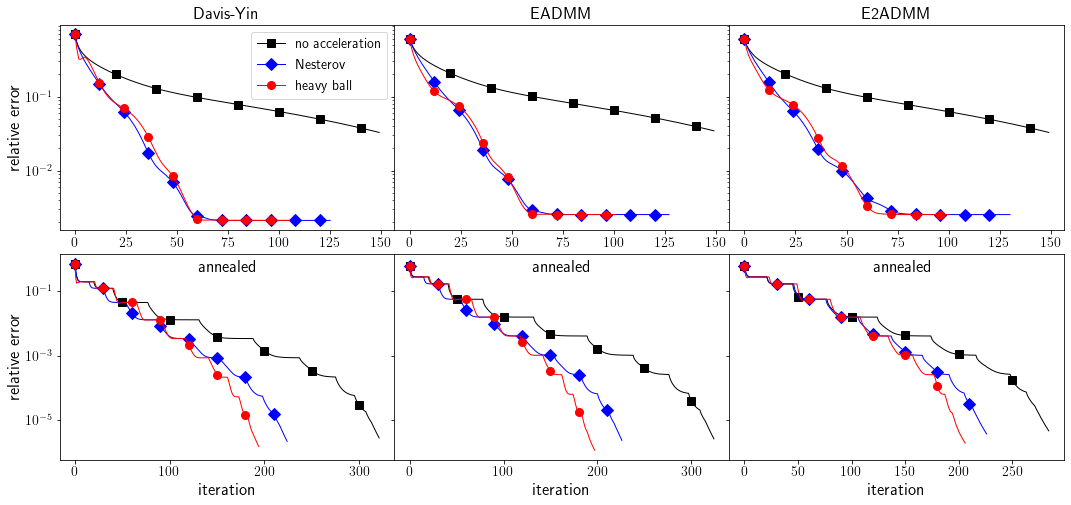

In [76]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(3*6, 2*4), sharey='row')

mi = 150
for row, err in zip(ax[0], [err_dy, err_eadmm, err_e2admm]):
    row.set_yscale('log')
    row.plot(err[0][:mi], color=color['None'], linestyle=line['None'], marker=marker['None'], markevery=20, label='no acceleration')
    row.plot(err[1][:mi], color=color['nest'], linestyle=line['nest'], marker=marker['nest'], markevery=12, label='Nesterov')
    row.plot(err[2][:mi], color=color['hb'], linestyle=line['hb'], marker=marker['hb'], markevery=12, label='heavy ball')
    
for row, err in zip(ax[1], [res_anneal_dy, res_anneal_eadmm, res_anneal_e2admm]):
    row.set_yscale('log')
    row.plot(err[0], color=color['None'], marker=marker['None'], markevery=50)
    row.plot(err[2], color=color['nest'], marker=marker['nest'], markevery=30)
    row.plot(err[4], color=color['hb'], marker=marker['hb'], markevery=30)

ax[0][0].set_ylabel('relative error')
ax[1][0].set_ylabel('relative error')
ax[1][0].set_xlabel('iteration')
ax[1][1].set_xlabel('iteration')
ax[1][2].set_xlabel('iteration')

ax[0][0].set_title('Davis-Yin')
ax[0][1].set_title('EADMM')
ax[0][2].set_title('E2ADMM')

#ax[1][0].set_title('Davis-Yin (annealed)')
#ax[1][1].set_title('EADMM (annealed)')
#ax[1][2].set_title('E2ADMM (annealed)')

ax[1,0].text(130, 0.4, 'annealed', fontsize='large')
ax[1,1].text(130, 0.4, 'annealed', fontsize='large')
ax[1,2].text(120, 0.4, 'annealed', fontsize='large')

ax[0][0].legend(loc=0)

plt.subplots_adjust(wspace=0, hspace=0.12)

fig.savefig('figs/convergence.pdf', bbox_inches='tight')

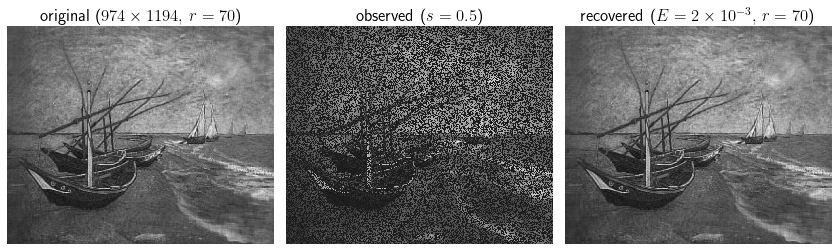

In [81]:
# write one of the recovered matrices
with open('data/easyfr_recoverred_dyhb.pickle','rb') as f:
    X = pickle.load(f)

fig, ax =plt.subplots(nrows=1,ncols=3,figsize=(3*5,1*4))

ax[0].imshow(M, cmap='gray')
ax[0].axis('off')
ax[0].set_title(r'original ($974 \times 1194, \, r=70$)')

ax[1].imshow(Mobs, cmap='gray')
ax[1].set_title(r'observed ($s=0.5$)')
ax[1].axis('off')

ax[2].imshow(X, cmap='gray')
ax[2].set_title(r'recovered ($E = 2 \times 10^{-3}, \, r=70$)')
ax[2].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig('figs/boats.pdf', bbox_inches='tight')

# Hard problem

In [24]:
# a hard problem
# This is the problem we will use in the paper

M = img_low_rank

n1,n2 = M.shape             # matrix size
r = 70                      # rank
sr = 0.3                    # sampling ratio
p = int(sr*n1*n2)           # number sampled entries
fr = r*(n1+n2-r)/p          # effective degrees of freedom per measurement
rm = int(np.floor((n1+n2-np.sqrt((n1+n2)**2 - 4*p))/2)) # maximum rank
X0 = np.zeros(shape=(n1,n2))

Mnorm = np.linalg.norm(M)
Mask = make_support(M.shape, p) # support of observed entries
Mobs2 = Mask*M

t = PrettyTable()
t.field_names = ['rank', 'sampling ratio', 'deg freedom/measurements']
t.add_row([r, sr, fr])
print(t)
print(Mobs2.min(), Mobs2.max(), Mobs2.std())

+------+----------------+--------------------------+
| rank | sampling ratio | deg freedom/measurements |
+------+----------------+--------------------------+
|  70  |      0.3       |    0.4209397912212012    |
+------+----------------+--------------------------+
-0.12662931880050182 1.1271742504732258 0.20677521899867038


In [3]:
np.log(0.9)

-0.10536051565782628

In [97]:
mu = 1
l1 = -0.15
l2 = 1.15
k = 150
#r_nest = 20
r_nest = 3
#r_hb = -np.log(0.65)
r_hb = -np.log(0.9)
tol = 1e-6
maxiter = 600

# Davis-Yin
a = time.time()
X1, rank1 = three_split.davis_yin(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel=None,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X1[-1]-M)/Mnorm, rank1[-1], b)

a = time.time()
X2, rank2 = three_split.davis_yin(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='nest',damp=r_nest,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X2[-1]-M)/Mnorm, rank2[-1], b)

a = time.time()
X3, rank3 = three_split.davis_yin(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='hb',damp=r_hb,l1=l1,l2=l2)
b = time.time()-a
print(np.linalg.norm(X3[-1]-M)/Mnorm, rank3[-1], b)

# ADMM
# a = time.time()
# X4, rank4 = three_split.eadmm(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel=None,l1=l1,l2=l2)
# b = time.time()-a
# print(np.linalg.norm(X4[-1]-M)/Mnorm, rank4[-1], b)

# a = time.time()
# X5, rank5 = three_split.eadmm(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='nest',damp=r_nest,l1=l1,l2=l2)
# b = time.time()-a
# print(np.linalg.norm(X5[-1]-M)/Mnorm, rank5[-1], b)

# a = time.time()
# X6, rank6 = three_split.eadmm(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='hb',damp=r_hb,l1=l1,l2=l2)
# b = time.time()-a
# print(np.linalg.norm(X6[-1]-M)/Mnorm, rank6[-1], b)

# #############

# a = time.time()
# X1, rank1 = three_split.e2admm(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel=None,l1=l1,l2=l2)
# b = time.time()-a
# print(np.linalg.norm(X1[-1]-M)/Mnorm, rank1[-1], b)

# a = time.time()
# X2, rank2 = three_split.e2admm(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='nest',damp=r_nest,l1=l1,l2=l2)
# b = time.time()-a
# print(np.linalg.norm(X2[-1]-M)/Mnorm, rank2[-1], b)

# a = time.time()
# X3, rank3 = three_split.e2admm(Mobs2,Mask,X0,mu=mu,stepsize=1,k=k,tol=tol,maxiter=maxiter,accel='hb',damp=r_hb,l1=l1,l2=l2)
# b = time.time()-a
# print(np.linalg.norm(X3[-1]-M)/Mnorm, rank3[-1], b)

0.07864985796783001 70 39.447691917419434
0.07864843215460526 70 47.811347007751465
0.07864845686700683 70 37.59816122055054


In [98]:
err1 = [np.linalg.norm(x - M)/np.linalg.norm(M) for x in X1]
err2 = [np.linalg.norm(x - M)/np.linalg.norm(M) for x in X2]
err3 = [np.linalg.norm(x - M)/np.linalg.norm(M) for x in X3]

with open('data/hard_dy_single_results.pickle', 'wb') as f:
    pickle.dump([err1, err2, err3, rank1, rank2, rank3], f)

In [95]:
err4 = [np.linalg.norm(x - M)/np.linalg.norm(M) for x in X4]
err5 = [np.linalg.norm(x - M)/np.linalg.norm(M) for x in X5]
err6 = [np.linalg.norm(x - M)/np.linalg.norm(M) for x in X6]

with open('data/hard_eadmm_single_results.pickle', 'wb') as f:
    pickle.dump([err4, err5, err6, rank4, rank5, rank6], f)

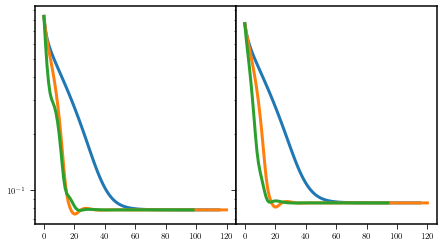

In [99]:
fig, axs = plt.subplots(nrows=1,ncols=2,sharey=True,sharex=True,figsize=(7.2,4))
ax1, ax2 = axs
ax1.set_yscale('log')
ax2.set_yscale('log')

ax1.plot(err1)
ax1.plot(err2)
ax1.plot(err3)

ax2.plot(err4)
ax2.plot(err5)
ax2.plot(err6)

plt.subplots_adjust(hspace=0,wspace=0)

plt.show()

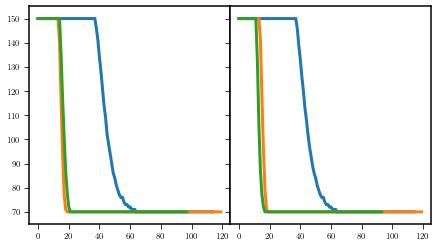

In [100]:
fig, axs = plt.subplots(nrows=1,ncols=2,sharey=True,sharex=True,figsize=(7.2,4))
ax1, ax2 = axs

ax1.plot(rank1[1:])
ax1.plot(rank2[1:])
ax1.plot(rank3[1:])
ax1.set_ylim([65,155])
ax2.plot(rank4[1:])
ax2.plot(rank5[1:])
ax2.plot(rank6[1:])

plt.subplots_adjust(hspace=0,wspace=0)

plt.show()

In [116]:
with open('data/hard_admm_hb_single_reco.pickle', 'wb') as f:
    pickle.dump([X6[-1]], f)

In [111]:
# with annealing
# this takes time and uses a lot of memory
# run each version separate and write to the file below, commenting the appropriate part of the code

mu = 1
l1 = -0.15
l2 = 1.15
k = 150
#r_nest = 20
r_nest = 3
#r_hb = -np.log(0.65)
r_hb = -np.log(0.9)
tol = 1e-6
maxiter = 600

## choose annealing schedule #######
eta = 0.25
mu = eta*np.linalg.norm(Mobs2)
mubar = 1e-4
mus = []
while mu > mubar:
    mu = np.max([eta*mu, mubar])
    mus.append(mu)


# a = time.time()
# X, rank, Xhist, rankhist = utils.warm(three_split.davis_yin,Mobs2,Mask,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel=None)
# b = time.time()-a
# print(np.linalg.norm(X-M)/np.linalg.norm(M), rank, b)

# a = time.time()
# X, rank, Xhist, rankhist = utils.warm(three_split.davis_yin,Mobs2,Mask,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='nest',damp=r_nest)
# b = time.time()-a
# print(np.linalg.norm(X-M)/np.linalg.norm(M), rank, b)

# a = time.time()
# X, rank, Xhist, rankhist = utils.warm(three_split.davis_yin,Mobs2,Mask,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='hb',damp=r_hb)
# b = time.time()-a
# print(np.linalg.norm(X-M)/np.linalg.norm(M), rank, b)

##############

# a = time.time()
# X, rank, Xhist, rankhist = utils.warm(three_split.eadmm,Mobs2,Mask,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel=None)
# b = time.time()-a
# print(np.linalg.norm(X-M)/np.linalg.norm(M), rank, b)

# a = time.time()
# X, rank, Xhist, rankhist = utils.warm(three_split.eadmm,Mobs2,Mask,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='nest',damp=r_nest)
# b = time.time()-a
# print(np.linalg.norm(X-M)/np.linalg.norm(M), rank, b)

a = time.time()
X, rank, Xhist, rankhist = utils.warm(three_split.eadmm,Mobs2,Mask,mus=mus,stepsize=1,k=k,l1=l1,l2=l2,tol=tol,maxiter=maxiter,accel='hb',damp=r_hb)
b = time.time()-a
print(np.linalg.norm(X-M)/np.linalg.norm(M), rank, b)



0.0005344513100527767 77 509.06831097602844


In [ ]:
# hb:   0.0014751462640850846 150 397.52793884277344
# nest: 0.00023770091110329714 72 346.36498498916626
# non accelerated: 0.0031469500382604425 150 518.1546492576599


In [50]:
500./60

8.333333333333334

In [109]:
with open('data/hard_admm_nest_reco.pickle', 'wb') as f:
    pickle.dump([X], f)

In [102]:
# no acceleration
harderrors1 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
hardranks1 = [r for hist in rankhist for r in hist]

In [107]:
# nesterov
harderrors2 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
hardranks2 = [r for hist in rankhist for r in hist]

In [112]:
# heavy ball
harderrors3 = [np.linalg.norm(x-M)/np.linalg.norm(M) for hist in Xhist for x in hist]
hardranks3 = [r for hist in rankhist for r in hist]

In [93]:
# outcome of Davis-Yin with non acceleration: 
# 0.0035215859789830698 150 766.851968050003  
with open('data/hard_dy_annealing_noaccell.pickle', 'wb') as f:
    pickle.dump([harderrors1, hardranks1], f)

# davis-yin with nesterov acceleration
# 0.00015660277383090665 71 684.9864530563354
with open('data/hard_dy_annealing_nest.pickle', 'wb') as f:
    pickle.dump([harderrors2, hardranks2], f)

# davis-yin with heavy ball acceleration
# 0.0005343848669413402 77 535.7635216712952
with open('data/hard_dy_annealing_hb.pickle', 'wb') as f:
     pickle.dump([harderrors3, hardranks3], f)


In [113]:
# outcome of ADMM with non acceleration: 
# 0.00352171282036421 150 797.9736518859863

#with open('data/hard_admm_annealing_noaccell.pickle', 'wb') as f:
#    pickle.dump([harderrors1, hardranks1], f)

# ADMM with nesterov acceleration
# 0.00015668171037163842 71 697.3146719932556
#with open('data/hard_admm_annealing_nest.pickle', 'wb') as f:
#    pickle.dump([harderrors2, hardranks2], f)

# ADMM with heavy ball acceleration
# 0.0005344513100527767 77 509.06831097602844
with open('data/hard_admm_annealing_hb.pickle', 'wb') as f:
    pickle.dump([harderrors3, hardranks3], f)


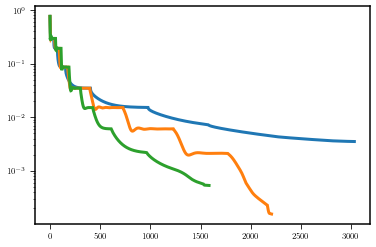

In [114]:
fig = plt.figure()
ax = fig.add_subplot(111)
ax.set_yscale('log')
ax.plot(harderrors1)
ax.plot(harderrors2)
ax.plot(harderrors3)
plt.show()

In [32]:
# getting all the data to plot

with open('data/hard_dy_single_results.pickle', 'rb') as f:
    err1, err2, err3, rank1, rank2, rank3 = pickle.load(f)

with open('data/hard_dy_annealing_noaccell.pickle', 'rb') as f:
    aerr1, arank1 = pickle.load(f)

with open('data/hard_dy_annealing_nest.pickle', 'rb') as f:
    aerr2, arank2 = pickle.load(f)

with open('data/hard_dy_annealing_hb.pickle', 'rb') as f:
    aerr3, arank3 = pickle.load(f)


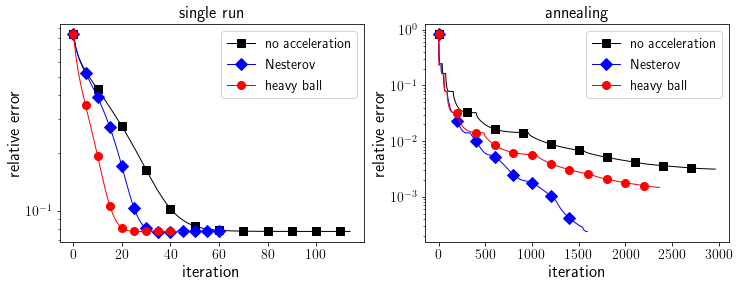

In [58]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*6,4))

ax = axes[0]
ax.set_yscale('log')
ax.plot(err1, '-', color='black', label='no acceleration', marker='s', markevery=10)
ax.plot(err2, '-', color='blue', label='Nesterov', marker='D', markevery=5)
ax.plot(err3, '-', color='red', label='heavy ball', marker='o', markevery=5)
ax.legend(loc=0)
ax.set_title('single run')
ax.set_ylabel('relative error')
ax.set_xlabel('iteration')

ax = axes[1]
ax.set_yscale('log')
ax.plot(aerr1, '-', color='black', label='no acceleration', marker='s', markevery=300)
ax.plot(aerr2, '-', color='blue', label='Nesterov', marker='D', markevery=200)
ax.plot(aerr3, '-', color='red', label='heavy ball', marker='o', markevery=200)
ax.legend(loc=0)
ax.set_title('annealing')
ax.set_ylabel('relative error')
ax.set_xlabel('iteration')

# ax = axes[2]
# ax.plot(arank1, '-', color='black', label='no acceleration', marker='s', markevery=300)
# ax.plot(arank2, '-', color='blue', label='Nesterov', marker='D', markevery=200)
# ax.plot(arank3, '-', color='red', label='heavy ball', marker='o', markevery=200)
# ax.legend(loc=0)
# ax.set_title('annealing')
# ax.set_ylabel('rank')
# ax.set_xlabel('iteration')

fig.savefig('figs/hard_convergence.pdf', bbox_inches='tight')

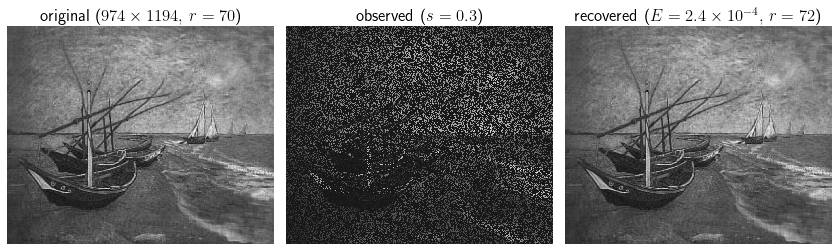

In [69]:
with open('data/hard_dy_nest_reco.pickle', 'rb') as f:
    X, = pickle.load(f)
    
fig, ax =plt.subplots(nrows=1,ncols=3,figsize=(3*5,1*4))

ax[0].imshow(M, cmap='gray')
ax[0].axis('off')
ax[0].set_title(r'original ($974 \times 1194, \, r=70$)')

ax[1].imshow(Mobs2, cmap='gray')
ax[1].set_title(r'observed ($s=0.3$)')
ax[1].axis('off')

ax[2].imshow(X, cmap='gray')
ax[2].set_title(r'recovered ($E = 2.4 \times 10^{-4}, \, r=72$)')
ax[2].axis('off')

plt.subplots_adjust(wspace=0, hspace=0)

fig.savefig('figs/boats2.pdf', bbox_inches='tight')

In [117]:
with open('data/im_original_observed.pickl', 'wb') as f:
    pickle.dump([M,Mobs2], f)